# W266 Final Project - Testing Out Longformer Model

**Description:** 

- This notebook tests out the performance of the longformer model, presented in "Longformer: The Long-Document Transformer" by Iz Beltagy, Matthew E. Peters, Arman Cohan (https://arxiv.org/abs/2004.05150).
- The model was pre-trained for MDS (multi-document summarization) in the PRIMERA model (vide "PRIMERA: Pyramid-based Masked Sentence Pre-training for Multi-document Summarization" at https://arxiv.org/abs/2110.08499).

## Setup

In [1]:
import evaluate
from pprint import pprint

## For printing out model summary in PyTorch
from torchvision import models
from torchsummary import summary

## General plotting
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Managing memory
import gc
import pickle

In [2]:
from datasets import load_dataset, load_metric

In [3]:
## Checking if GPU is available when running locally
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



## 1. Importing Longformer Model

### 1.1 Preliminaries

- Uses the HuggingFace model (https://huggingface.co/docs/transformers/model_doc/led).  This is the model with both encoder and decoder, and trained on summarization task using the arxiv dataset.
- The encoder only version is at https://huggingface.co/docs/transformers/model_doc/longformer).

In [4]:
## Importing model
from transformers import LEDModel, LEDConfig, LEDTokenizer, AutoTokenizer, LEDForConditionalGeneration

In [29]:
## Loading check point

LEDmodel = LEDForConditionalGeneration.from_pretrained("allenai/led-large-16384-arxiv").to("cuda").half()
LEDtokenizer = AutoTokenizer.from_pretrained("allenai/led-large-16384-arxiv")

# LEDtokenizer2 = LEDTokenizer.from_pretrained("allenai/led-large-16384-arxiv")

# LEDmodel = LEDModel.from_pretrained("allenai/led-base-16384")
# LEDtokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")

In [7]:
## Loading rouge
rouge = load_metric("rouge")

### 1.2 Model summary and config

In [6]:
## Summary of model
print(summary(LEDmodel))

Layer (type:depth-idx)                             Param #
├─LEDModel: 1-1                                    --
|    └─Embedding: 2-1                              51,471,360
|    └─LEDEncoder: 2-2                             --
|    |    └─Embedding: 3-1                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-2     16,777,216
|    |    └─ModuleList: 3-3                        188,940,288
|    |    └─LayerNorm: 3-4                         2,048
|    └─LEDDecoder: 2-3                             --
|    |    └─Embedding: 3-5                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-6     1,048,576
|    |    └─ModuleList: 3-7                        201,560,064
|    |    └─LayerNorm: 3-8                         2,048
├─Linear: 1-2                                      51,471,360
Total params: 511,272,960
Trainable params: 511,272,960
Non-trainable params: 0
Layer (type:depth-idx)                             Param #
├─LEDModel: 1-1            

In [8]:
## Seeing the configuration options.

config = LEDConfig.from_pretrained("allenai/led-large-16384-arxiv")
# config = LEDConfig.from_pretrained("allenai/led-base-16384")
config

LEDConfig {
  "_name_or_path": "./",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_decoder_po

### 1.3 Tests using manual examples

- To try out selected manually prepared examples, just to get a feel of how the model behaves.

#### 1.3.1 Example 1 - Sample text from Arxiv (from HuggingFace example)
- Somehow, the model just extracts a sentence without much major change.

In [68]:
ARTICLE_TO_SUMMARIZE = '''Transformers (Vaswani et al., 2017) have achieved state-of-the-art
    results in a wide range of natural language tasks including generative language modeling
    (Dai et al., 2019; Radford et al., 2019) and discriminative ... language understanding (Devlin et al., 2019).
    This success is partly due to the self-attention component which enables the network to capture contextual
    information from the entire sequence. While powerful, the memory and computational requirements of
    self-attention grow quadratically with sequence length, making it infeasible (or very expensive) to
    process long sequences. To address this limitation, we present Longformer, a modified Transformer
    architecture with a self-attention operation that scales linearly with the sequence length, making it
    versatile for processing long documents (Fig 1). This is an advantage for natural language tasks such as
    long document classification, question answering (QA), and coreference resolution, where existing approaches
    partition or shorten the long context into smaller sequences that fall within the typical 512 token limit
    of BERT-style pretrained models. Such partitioning could potentially result in loss of important
    cross-partition information, and to mitigate this problem, existing methods often rely on complex
    architectures to address such interactions. On the other hand, our proposed Longformer is able to build
    contextual representations of the entire context using multiple layers of attention, reducing the need for
    task-specific architectures.'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=48, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' we present a modified version of the transformer ( vaswani et al. \n, 2017 ) architecture with a self-attention operation that scales linearly with the sequence length, making it versatile for processing long documents.']

#### 1.3.2 Example 2 - Training examplen from Multinews (Part 1)
- Somehow, the model just extracts a sentence without much major change.
- Correct summary is: **"– The unemployment rate dropped to 8.2% last month, but the economy only added 120,000 jobs, when 203,000 new jobs had been predicted, according to today's jobs report. Reaction on the Wall Street Journal's MarketBeat Blog was swift: "Woah!!! Bad number." The unemployment rate, however, is better news; it had been expected to hold steady at 8.3%. But the AP notes that the dip is mostly due to more Americans giving up on seeking employment."** *(74 words)*
- The answer is quite far-off, without much mentioning of the key job figures.
- Note that for Multi-news, the " ||||| " probably signals the start of another article.
- If we follow the PRIMERA paper, this symbol should probably be replaced by special tokens and be given global (instead of local) attention.

In [74]:
ARTICLE_TO_SUMMARIZE = '''National Archives Yes, it’s that time again, folks. 
It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,
Washington and Main Street are all aligned on one thing: Jobs. A fresh update on the U.S. employment
situation for January hits the wires at 8:30 a.m. New York time offering one of the most important 
snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs 
to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added
in February. The unemployment rate is expected to hold steady at 8.3%. Here at MarketBeat HQ, we’ll be
offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself,
via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. 
Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. 
economy may not be growing fast enough to sustain robust job growth. The unemployment rate dipped, 
but mostly because more Americans stopped looking for work. The Labor Department says the economy added 
120,000 jobs in March, down from more than 200,000 in each of the previous three months. The unemployment 
rate fell to 8.2 percent, the lowest since January 2009. The rate dropped because fewer people searched 
for jobs. The official unemployment tally only includes those seeking work. The economy has added 858,000 
jobs since December _ the best four months of hiring in two years. But Federal Reserve Chairman Ben Bernanke 
has cautioned that the current hiring pace is unlikely to continue without more consumer spending.'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=128, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' this is a preview of our live coverage of the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it will be our pleasure to provide color commentary before and after the data crosses the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Feel free to weigh-in yourself,via the comments section.  enjoy the show. ']

#### 1.3.2 Example 2 - Part 2
- And interestingly, if we remove the " ||||| " part, the model just fails to perform normally.

In [75]:
ARTICLE_TO_SUMMARIZE = '''National Archives Yes, it’s that time again, folks. 
It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,
Washington and Main Street are all aligned on one thing: Jobs. A fresh update on the U.S. employment
situation for January hits the wires at 8:30 a.m. New York time offering one of the most important 
snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs 
to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added
in February. The unemployment rate is expected to hold steady at 8.3%. Here at MarketBeat HQ, we’ll be
offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself,
via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. 
Enjoy the show. Employers pulled back sharply on hiring last month, a reminder that the U.S. 
economy may not be growing fast enough to sustain robust job growth. The unemployment rate dipped, 
but mostly because more Americans stopped looking for work. The Labor Department says the economy added 
120,000 jobs in March, down from more than 200,000 in each of the previous three months. The unemployment 
rate fell to 8.2 percent, the lowest since January 2009. The rate dropped because fewer people searched 
for jobs. The official unemployment tally only includes those seeking work. The economy has added 858,000 
jobs since December _ the best four months of hiring in two years. But Federal Reserve Chairman Ben Bernanke 
has cautioned that the current hiring pace is unlikely to continue without more consumer spending.'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=128, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' it is that time of the month again, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it is the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it is the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it is the first Friday of the month, when']

#### 1.3.2 Example 2 - Part 3
- Now we try to actually separate the two articles, give each of them a proper global attention leading token, concatenate them again, and see how the model responds.
- The answer seems much more reasonable, though towards the end some random tokens are spit out.

In [95]:
ARTICLE_TO_SUMMARIZE = '''National Archives Yes, it’s that time again, folks. 
It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,
Washington and Main Street are all aligned on one thing: Jobs. A fresh update on the U.S. employment
situation for January hits the wires at 8:30 a.m. New York time offering one of the most important 
snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs 
to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added
in February. The unemployment rate is expected to hold steady at 8.3%. Here at MarketBeat HQ, we’ll be
offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself,
via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. 
Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. 
economy may not be growing fast enough to sustain robust job growth. The unemployment rate dipped, 
but mostly because more Americans stopped looking for work. The Labor Department says the economy added 
120,000 jobs in March, down from more than 200,000 in each of the previous three months. The unemployment 
rate fell to 8.2 percent, the lowest since January 2009. The rate dropped because fewer people searched 
for jobs. The official unemployment tally only includes those seeking work. The economy has added 858,000 
jobs since December _ the best four months of hiring in two years. But Federal Reserve Chairman Ben Bernanke 
has cautioned that the current hiring pace is unlikely to continue without more consumer spending.'''

part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = LEDtokenizer(part1, return_tensors="pt")
inputs2 = LEDtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)

predicted_abstract_ids = LEDmodel.generate(inputs,
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=128, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' we present a preview of the economic data for the month of january, which will be released at 8:30 a.m. New York time. \n we will focus on the job creation report for the month of january, which is expected to show 203,000 new jobs added in the month of january, compared to 227,000 jobs added in the previous month. \n the unemployment rate is expected to hold steady at 8.3%.    \n # 1_#1 _ # 1_#1 _ =    # 1 1.25 in.125 in.25 in']

#### 1.3.3 Example 3 - A longer training examplen from Multinews (Part 1)
- Since LED is about "long" inputs, let's see how it behaves for a longer article.
- Correct summary is: **"– A twin-engine Embraer jet that the FAA describes as "on approach to Runway 14" at the Montgomery County Airpark in Gaithersburg, Maryland, crashed into a home this morning, engulfing that home in flames and setting two others on fire. Three people are dead, but the count could grow. A Montgomery County Fire rep says three fliers were killed in the crash, but notes the corporate plane may have had a fourth person on board, reports the AP. A relative of the owner of the home that was hit tells WUSA 9 that a mother with three children pre-school age and under should have been home at the time; there's no word on the family's whereabouts. The crash occurred around 11am on Drop Forge Lane, and the fire was extinguished within an hour. Crews are now searching the wreckage. A witness noted the plane appeared to "wobble" before the crash; the airport is no more than 3/4 mile from the crash scene. NTSB and FAA will investigate."**  *(166 words)*
- First, we try it without breaking up anything.
- Somehow the model is able to generate some relevant text but can't use up the word limit.  There are also strange texts towards the end.

In [98]:
ARTICLE_TO_SUMMARIZE = '''GAITHERSBURG, Md. (AP) — A small, private jet has crashed into
a house in Maryland's Montgomery County on Monday, killing at least three people on board,
authorities said. Preliminary information indicates at least three people were on board and
didn't survive the Monday crash into home in Gaithersburg, a Washington, D.C. suburb, said
Pete Piringer, a Montgomery County Fire and Rescue spokesman. He said a fourth person may have
been aboard. Piringer said the jet crashed into one home around 11 a.m., setting it and two
others on fire. Crews had the fire under control within an hour and were searching for anyone
who may have been in the homes. Television news footage of the scene showed one home nearly destroyed,
with a car in the driveway. Witnesses told television news crews that they saw the airplane appear
to struggle to maintain altitude before going into a nosedive and crashing. An FAA spokesman said
preliminary information shows the Embraer EMB-500/Phenom 100 twin-engine jet was on approach at the
nearby Montgomery County Airpark. The National Transportation Safety Board is sending an investigator
to the scene. ||||| Gemmell family (Photo: Facebook) GAITHERSBURG, Md. (WUSA9) -- The investigations 
into a plane crash that left six people dead in Gaithersburg on Monday evening are just beginning. 
A mother and her two young children are three of the six lives lost in the crash. Marie Gemmell, 36,
her three-year-old son Cole and her infant-son Devin were inside their home when a corporate jet crashed
into it. Their bodies were found on the second floor hours after the crash. The father and a third child
were not home at the time of the crash. Michael Rosenberg was on the jet that crashed (Photo: Health Decisions)
Three people on the jet were also killed, according to Montgomery County fire officials. One of those victims
has been identified as Michael Rosenberg, CEO of Health Decisions. You can read their statement here. An Embraer
EMB-500/Phenom 100 crashed into a house in the 19700 block of Drop Forge Lane off Snouffer School Road in the 
neighborhood of Hunters Woods around 10:45 a.m., according to the NTSB. The plane was coming from Chapel Hill, 
NC and approaching the Montgomery County Air Park. The NTSB has sent a go-team to the site, where three homes 
were damaged. Firefighters used foam to battle fires all around the scene. The fuselage of the jet is parallel 
to a second house, and the tail of the airplane is at the front door. One of the wings was catapulted into the 
Gemmell's house, causing a huge fire and the majority of the damage, according to the NTSB. Senior Investigator 
Timothy LeBaron is leading the go-team. Investigators are looking at operations, including crew experience, training
and procedures, the functionality of the engines, the weather, air traffic control and more, NTSB spokesperson 
Robert L. Sumwalt said at a press confrence. "Our mission is to find out not only what happened, but why it happened
because we want to make sure something like this never happens again," Sumwalt said. MORE: Woman says community feared
plane crash NTSB investigators are currently collecting perishable evidence, not determining the cause. They'll be
conducting interviews and documenting the wreckage. Investigators could be on the scene for three to seven days for
what they call the "fact-finding" phase. The black box, which has recordings from the crash, has been recovered. It
is in good condition and has been rushed to labs, Sumwalt said. The first call about the crash came in at 10:44 a.m.
from the National Guard Armory for the report of an explosion, and units were on the scene in approximately seven 
minutes, Montgomery County Fire Chief Steve Lohr said at an initial press conference. Utility crews were also on the
scene and Lorh said it is safe for residents in the area. Electricity has been temporarily cut off. Recordings of the
911-calls from the crash were released on Monday evening. In the recordings neighbors and witnesses describe the scene
where the plane crashed in the Gaithersburg neighborhood. Recordings of the 911 calls from the Gaithersburg plane crash
were released on Monday evening. "We just heard a giant explosion we looked out the window and there's... it looks 
like a house is on fire, we've got some people running over there to see if people are okay," one caller described. 
RAW: Fire Chief Steve Lohr speaks on plane crash A woman who was traveling into the area after taking a test at 
Montgomery College tells WUSA9 that she could see the smoke from the crash from I-370. As she got closer, she saw all
the emergency response vehicles and called her husband. He told her that the smoke was coming from the area where her
mother and stepfather lived and she says she got worried. She discovered the house that was struck was their neighbors'
house. She says there are "three little ones" who live in that house. One person reported seeing the plane "wobble"
before it crashed into the house. Other neighbors reported hearing repeated booms and feeling their houses shake 
from the impact of the plane. Something went wrong with the jet heading to the Montgomery County airport and it went
into a house in Gaithersburg WUSA9 spoke with an eyewitness named Jocelyn Brown who said she first heard the plane 
sputtering, making a sound that planes that go over the area normally don't make flying over the houses. She says she
and her mother became concerned and went to investigate. They then saw the plane hit the side of a house. She reported
seeing a "mushroom effect of smoke" and also hearing three explosions after the plane hit. Jocelyn says they also heard
screams in the area of the home. She says she does not know whether they were coming from inside the house or behind
them. Jocelyn lives in the area and says she knows the mother that lives there. She described her as a "sweet woman"
who walks with her kids in the area all the time and speaks to everyone. He said the plane sounded like it was
"puttering" and then saw fire A woman posted video from the ground of the scene of the plane crash on YouTube. . 
The FAA has released the following information: "This is preliminary information about an Embraer EMB-500/Phenom 100
twin-engine jet that crashed one mile north of the Montgomery County Airport, Gaithersburg, MD at 11am today. The 
aircraft was on approach to Runway 14 at the airport when the accident occurred. Please contact local authorities 
for information on passengers and the situation on the ground. The FAA will investigate. We will update this statement
when new information is available. " Photo of plane from FlightAware (Photo: FlightAware) An FAA source says the jet 
was waiting for a much slower single engine aircraft, possibly a Cessna, to make its turn so it could make its approach.
That information has not been confirmed by the NTSB. The Montgomery County Air Park is within 1/2 to 3/4 of a mile of 
the crash. The airport does not have a tower, so communication would have been with Washington Air Traffic Control 
Section, not the airport. The FAA registry shows that the plane was a corporate Phenom jet with tail number N100EQ. 
It's registered to Sage Aviation LLC out of Chapel Hill, NC which makes replacement parts for the aviation industry. 
MORE: Gaithersburg plane crash at Drop Forge Lane, 3 houses suffering some sort of damage, this one the worst
@WNEWpic.twitter.com/vihz4k5eYE — JimMacKayWNEW (@JimMacKayWNEW) December 8, 2014 Snouffer School Road was closed 
between Centerway Road and Goshen Road following the crash. Drivers and pedestrians are being urged to avoid the area.
It is likely to remain closed throughout the night and possibly Tuesday. She says something has to be done about 
planes flying low directly over homes. Read or Share this story: http://on.wusa9.com/1A8PzKE"'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, # Customized in view of the length of the reference summary
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' the investigation into a plane crash that left six people dead in Gaithersburg on Monday evening is just beginning. \n a mother and her two young children are three of the six lives lost in the crash. Something went wrong with the jet heading to the Montgomery County airport and it went into a house in Gaithersburg, a Washington, D.C. suburb. \n three people on the jet were also killed, according to Montgomery County fire officials. \n the plane was coming from Chapel Hill,  \n NC and approaching the Montgomery County Air Park.    \n # 1_#1 _ # 1_#1 _ =    # 1 1.25 in.125 in.25 in ']

#### 1.3.3 Example 3 (Part 2)
- Since the out put was quite a bit shorter than the reference, I have tried adding in a "min_length" parameter which is not in the configuration.  Naturally, it seems to do nearly nothing.

In [106]:
predicted_abstract_ids2 = LEDmodel.generate(inputs['input_ids'],
                                            attention_mask=inputs['attention_mask'], 
                                            global_attention_mask=global_attention_mask, 
                                            min_length=150, # min_length is not a config and seems to do nothing
                                            max_length=200, 
                                            num_beams=4)

LEDtokenizer.batch_decode(predicted_abstract_ids2, skip_special_tokens=True)

[' the investigation into a plane crash that left six people dead in Gaithersburg on Monday evening is just beginning. \n a mother and her two young children are three of the six lives lost in the crash. Something went wrong with the jet heading to the Montgomery County airport and it went into a house in Gaithersburg, a Washington, D.C. suburb. \n three people on the jet were also killed, according to Montgomery County fire officials. \n the plane was coming from Chapel Hill, \n NC and approaching the Montgomery County Air Park when it crashed into the house.    \n # 1_#1 _ # 1_#1 _ =    # 1 1.25 in.125 in.25 in ']

#### 1.3.3 Example 3 (Part 3)
- Let's try doing the split once more.
- Result is no good.  Perhaps we really need the \<doc-sep> token?  But that is not included in the LED tokenizer

In [109]:
part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = LEDtokenizer(part1, return_tensors="pt")
inputs2 = LEDtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)

predicted_abstract_ids = LEDmodel.generate(inputs,
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' a small, private jet has crashed into a house in the neighborhood of Hunters Woods on Monday morning, killing at least three people on board. \n the plane was on approach to the Montgomery County airport when it crashed into the house.    \n # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3']

In [41]:
## There is no <doc-sep> token in the LED tokenizer
LEDtokenizer("<doc-sep>", return_tensors="pt")

{'input_ids': tensor([[    0, 41552, 37447,    12,  1090,   642, 15698,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
## But it is present in the PRIMERA one
PRIMERAtokenizer = AutoTokenizer.from_pretrained('allenai/PRIMERA')

PRIMERAtokenizer("<doc-sep>", return_tensors="pt")

{'input_ids': tensor([[    0, 50265,     2]]), 'attention_mask': tensor([[1, 1, 1]])}

#### 1.3.3 Example 3 (Part 4)
- Perhaps let's try using the PRIMERA tokenizer.
- First, we try out the use of the tokenizer normally, i.e. without adding the \<doc-sep> token.
- Then we try adding in the \<doc-sep> token which is supported by the tokenizer.

In [126]:
## Experimenting with just the PRIMERA tokenizer first.  Answer seems to be that there is no effect whatsoever.
part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = PRIMERAtokenizer(part1, return_tensors="pt")
inputs2 = PRIMERAtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)

predicted_abstract_ids = LEDmodel.generate(inputs,
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, 
                                           num_beams=4)

predicted_abstract = PRIMERAtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' a small, private jet has crashed into a house in the neighborhood of Hunters Woods on Monday morning, killing at least three people on board. \n the plane was on approach to the Montgomery County airport when it crashed into the house.    \n # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3']

In [189]:
part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = PRIMERAtokenizer(part1, return_tensors="pt")
inputs2 = PRIMERAtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)


In [195]:
## Then we try adding that <doc-sep> tokenizer, but this causes errors 
## since token 50265 is out of bounds for the matrices in the LED model.
ARTICLE_TO_SUMMARIZE_2 = ARTICLE_TO_SUMMARIZE.replace("|||||", "<doc-sep>")

inputs = PRIMERAtokenizer(ARTICLE_TO_SUMMARIZE_2, return_tensors="pt")

doc_sep_loc = list(inputs['input_ids'][0]).index(50265)
print(f"The location of the <doc-sep> token is {doc_sep_loc}.\n")

attention_mask = inputs['attention_mask']

global_attention_mask = torch.zeros_like(attention_mask)
global_attention_mask[:, 0] = 1           # <s> has global attention
global_attention_mask[:, doc_sep_loc] = 1 # <doc-sep> also has global attention

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, 
                                           num_beams=4)

predicted_abstract = PRIMERAtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

The location of the <doc-sep> token is 259.



IndexError: index out of range in self

# 2 The Multi_news dataset

## 2.1 Loading the dataset

In [9]:
## Loading the dataset
# multi_train = load_dataset('multi_news', split='train')
multi_val = load_dataset('multi_news', split='validation')
# multi_test = load_dataset('multi_news', split='test')

Found cached dataset multi_news (C:/Users/JustinTo/.cache/huggingface/datasets/multi_news/default/1.0.0/2f1f69a2bedc8ad1c5d8ae5148e4755ee7095f465c1c01ae8f85454342065a72)


In [10]:
## Tokenizing using LED Tokenizer (essentially the same as PRIMERA)
## Used for EDA and also subsequent model fitting

# train_inputs = LEDtokenizer(multi_train['document'],
#                             padding="max_length",
#                             max_length=16384,  # maximum sequence length is 16384
#                             return_tensors="pt",
#                             truncation=True)

val_inputs = LEDtokenizer(multi_val['document'],
                          padding="max_length",
                          max_length=16384,  # maximum sequence length is 16384
                          return_tensors="pt",
                          truncation=True)

# test_inputs = LEDtokenizer(multi_test['document'],
#                            padding="max_length",
#                            max_length=16384,  # maximum sequence length is 16384
#                            return_tensors="pt",
#                            truncation=True)

In [11]:
# train_labels = LEDtokenizer(multi_train['summary'],
#                             padding=True,
#                             return_tensors="pt")

val_labels = LEDtokenizer(multi_val['summary'],
                          padding=True,
                          return_tensors="pt")

# test_labels = LEDtokenizer(multi_test['summary'],
#                            padding=True,
#                            return_tensors="pt")

## 2.2 Exploratory Data Analysis (WIP to be continued)

The sizes are: (44972, 5622, 5622)


Text(0.5, 1.0, 'Size of Multi_News Dataset')

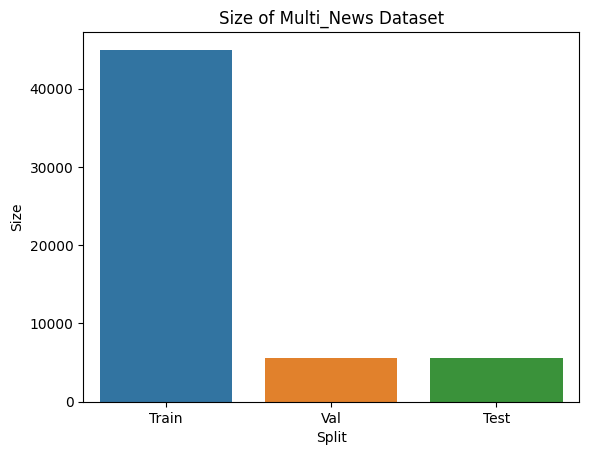

In [15]:
## Checking the size of the dataset
print(f"The sizes are: ({len(multi_train['document'])}, {len(multi_val['document'])}, {len(multi_test['document'])})")

multi_df = {"Split": ["Train", "Val", "Test"],
            "Size": [len(multi_train['document']), len(multi_val['document']), len(multi_test['document'])]}
multi_df = pd.DataFrame.from_dict(multi_df)

sns.barplot(data=multi_df, x="Split", y="Size")
plt.title("Size of Multi_News Dataset")

In [202]:
multi_train['summary'][0]

'– The unemployment rate dropped to 8.2% last month, but the economy only added 120,000 jobs, when 203,000 new jobs had been predicted, according to today\'s jobs report. Reaction on the Wall Street Journal\'s MarketBeat Blog was swift: "Woah!!! Bad number." The unemployment rate, however, is better news; it had been expected to hold steady at 8.3%. But the AP notes that the dip is mostly due to more Americans giving up on seeking employment.'

# 3 Testing Baseline Performance

## 3.1 Performance on Multi_news Validation Set (without Fine-tuning)

In [50]:
## Helper function to generate results

def generate_abstract_batched(batch_size=1, start=0):
    
    try:
        del val_input_ids, attention_mask, global_attention_mask, predicted_abstract_ids
    except:
        None
        
    gc.collect()

    val_input_ids = val_inputs['input_ids'][start:start+batch_size].to("cuda")
    attention_mask = val_inputs['attention_mask'][start:start+batch_size].to("cuda")

    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1

    predicted_abstract_ids = LEDmodel.generate(val_input_ids,
                                               attention_mask=attention_mask, 
                                               global_attention_mask=global_attention_mask, 
                                               max_length=200, 
                                               num_beams=4)

    predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    
    return predicted_abstract


In [59]:
## Generating answers
answers = []

for i in range(multi_val.shape[0]):
    if i%500 == 0:
        print(f"Handling sample {i} now..")
        
    answers.append(generate_abstract_batched(start=i))
    
print(f"Completed, {i+1} data points from the {multi_val.shape[0]} validation samples handled.")

Handling sample 0 now..
Handling sample 500 now..
Handling sample 1000 now..
Handling sample 1500 now..
Handling sample 2000 now..
Handling sample 2500 now..
Handling sample 3000 now..
Handling sample 3500 now..
Handling sample 4000 now..
Handling sample 4500 now..
Handling sample 5000 now..
Handling sample 5500 now..
Completed, 5622 data points from the 5622 validation samples handled.


In [80]:
## Calculating the rouge score
rouge.compute(predictions=answers,
              references=multi_val['summary'],
              rouge_types=["rouge1", "rouge2", "rougeL"])

{'rouge1': AggregateScore(low=Score(precision=0.45253162110316586, recall=0.26998620151089253, fmeasure=0.3241583836362227), mid=Score(precision=0.45642679639575445, recall=0.2729729530747623, fmeasure=0.3271969919816484), high=Score(precision=0.46016692175128177, recall=0.275729071344786, fmeasure=0.3299448519888343)),
 'rouge2': AggregateScore(low=Score(precision=0.14000755912845286, recall=0.08202769814712106, fmeasure=0.09892668187304138), mid=Score(precision=0.14275065311251173, recall=0.083671023832943, fmeasure=0.10081800237960234), high=Score(precision=0.1455922502482658, recall=0.08533408180476365, fmeasure=0.10269855845729314)),
 'rougeL': AggregateScore(low=Score(precision=0.24450394039490142, recall=0.1434096150673474, fmeasure=0.1724310740656986), mid=Score(precision=0.24720863688636047, recall=0.14505657121859272, fmeasure=0.17414673745136144), high=Score(precision=0.24996468673278543, recall=0.1468127556953943, fmeasure=0.17601751619539716))}

## 4 General Utilities

### 4.1 Saving results into pickles for future use

In [75]:
## Pickling input ids and labels for future use
with open("multinews_val_ids.pkl", "wb") as f:
    pickle.dump(val_inputs, f)
    
with open("multinews_val_labels.pkl", "wb") as f:
    pickle.dump(val_labels, f)
    
with open("multinews_val_text.pkl", "wb") as f:
    pickle.dump(multi_val, f)
    
## Pickling results
with open("LED_multinews_results1.pkl", "wb") as f:
    pickle.dump(answers, f)

### 4.2 Loading previous pickles

In [76]:
with open("multinews_val_ids.pkl", "rb") as f:
    val_inputs = pickle.load(f)
    
with open("multinews_val_labels.pkl", "rb") as f:
    val_labels = pickle.load(f)
    
with open("multinews_val_text.pkl", "rb") as f:
    multi_val = pickle.load(f)

with open("LED_multinews_results1.pkl", "rb") as f:
    answers = pickle.load(f)

## Unused cells - inherited from the assignment notebook and will be edited on later.

Look at the `task_specific_params` for summarization. You can see that this `t5-base` checkpoint has some values such as min_length and max_length as well as no_repeat_ngram_size and num_beams.  You can affect the size and content of the output by modifying these parameters which you will do below.

You can also look at the full set of possible parameters in the [TFGenerationMixin](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/text_generation#transformers.generation_tf_utils.TFGenerationMixin) class available to all of the pre-trained models.

HuggingFace has also written [a very helpful blog post](https://huggingface.co/blog/how-to-generate) that explains and discusses various strategies for text generation and how to manipulate the hyperparameters.  They discuss the two approaches of beam search (which we have discussed in the async and live session) as well as sampling (which tries to randomly pick the next word within a k-sized distribution of highly probable choices).  

**Please read the blog post before you proceed.**

For your reference, here's a more complex, technical, and thorough [HuggingFace guide](https://huggingface.co/docs/transformers/main/en/generation_strategies) for controlling generation of text.  The blog post above is all you need to read to complete the assignment.

### 1.b ROUGE for summarization evaluation

ROUGE is the metric that has been traditionally used to evaluate sumarization results.  The ROUGE metric expects a reference as input and it will evaluate a candidate against that reference.  ROUGE-1 calculates the number of words in the reference that occur in the candidate.  ROUGE-2 performs that same calculation but for bigrams in the reference. ROUGE-L calculates the longest common subsequence of reference words that occur in the candidate.

HuggingFace provides a wrapper around [a library](https://huggingface.co/spaces/evaluate-metric/rouge) to calculate ROUGE metrics which you will use below.  Let's calculate the ROUGE score for the candidate you produced above.

In [15]:
rouge = evaluate.load('rouge')
predictions = candidate
references = [SHORT_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.2702702702702703, 'rouge2': 0.1142857142857143, 'rougeL': 0.2702702702702703, 'rougeLsum': 0.2702702702702703}


Let's experiment with the hyperparameters shown above.  Please experiment in the cell below.  The `num_beams` value is like a beam search.  It indicates the number of tries the model makes before showing you its best output.  The `no_repeat_ngram_size` is designed to help reduce repetition in the output.  `min_length` and `max_length` set boundaries on the size of the summary. You are free to use other hyperparameters as described in the [blog post](https://huggingface.co/blog/how-to-generate).

*There is no one correct answer to these questions.  There are ranges that tend to work better than others.  The goal is to have you experiment to help build intuition.  Please enter the values that you think are generating the most readable output.* 

*Your readable output should consist of at least one complete sentence but does not have to end with a period and you must also have a ROUGE-1 score above 0.30 and ROUGE-L score equal to or above 0.25 when compared with the short reference.*

You can use the two cells below to come up with your answer.

In [22]:
# Generate Summary
summary_ids = t5model.generate(inputs["input_ids"], 
### YOUR CODE HERE       
                               early_stopping=True,
                               length_penalty=2.0,
                               max_length=30,
                               min_length=15,
                               no_repeat_ngram_size=3,
                               num_beams=4
#                               top_k=50, 
#                               top_p=0.95,
### END YOUR CODE                
)

candidate = t5tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(candidate[0], compact=True)

('PG&e shuts off power to 800 thousand customers in response to forecasts for '
 'high winds . the aim is to reduce the risk')


In [23]:
predictions = candidate
references = [SHORT_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.4583333333333333, 'rouge2': 0.2608695652173913, 'rougeL': 0.37499999999999994, 'rougeLsum': 0.37499999999999994}


**QUESTION:**

1.1 What num_beams value gives you the most readable output that meets the score criteria?

1.2 Which no_repeat_ngram_size gives the most readable output that meets the score criteria?

1.3 What min_length value gives you the most readable output that meets the score criteria?

1.4 Which max_length value gives the most readable output that meets the score criteria

**ANSWER:**

1.1 The value used is 4.

1.2 The value used is 3, ie the default value.

1.3 The value used is 15, given we are generating a short reference.

1.4 The value used is 30, to force the model generate shorter outputs for better Rouge scores.

In [24]:
#In order to not consume all of the memory available in Colab we'll free up the memory we're using for these large language models
del t5model
del t5tokenizer 


## 2. Pegasus for Headline Summarization 

Pegasus is an encoder decoder architecture that has been explicitly pre-trained as an abstractive summarizer.  You can read more about it [here](https://huggingface.co/docs/transformers/model_doc/pegasus) and [here](https://arxiv.org/pdf/1912.08777.pdf).

We'll first use the `google/pegasus-xsum` checkpoint.  It is trained on a [summarization task](https://aclanthology.org/D18-1206.pdf) that reads a news article and then [emits a one line summary](https://huggingface.co/datasets/xsum).  This doesn't mean that it is limited in its output length.  It does mean that it works well with news article type inputs and tends toward shorter outputs.

In [25]:
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration

pmodel = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
ptokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
pmodel.summary()

Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFPegasusMainLayer)  multiple                  569748480 
                                                                 
 final_logits_bias (BiasLaye  multiple                 96103     
 r)                                                              
                                                                 
Total params: 569,844,583
Trainable params: 569,748,480
Non-trainable params: 96,103
_________________________________________________________________


Let's see what kinds of default parameters are configured in to this checkpoint.

In [27]:
config = AutoConfig.from_pretrained("google/pegasus-xsum")

config

PegasusConfig {
  "_name_or_path": "google/pegasus-xsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 0,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,


Generate the inputs using the pegasus tokenizer for this checkpoint.

In [28]:
inputs = ptokenizer(ARTICLE_TO_SUMMARIZE, max_length=1024, truncation=True, return_tensors="tf")

Let's get some output using just the default values and see what we're working with.

In [29]:
# Generate Summary
summary_ids = pmodel.generate(inputs["input_ids"] 
)
pprint(ptokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0], compact=True)

/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:702: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


("California's largest utility has announced plans to cut power to hundreds of "
 'thousands of customers in a bid to reduce the risk of wildfires.')


Let's experiment with the same set of hyperparameters for the Pegasus system.  It is designed for abstractive summarization. Remember that the checkpoint we are using was trained on data that generates a one line summary for the input article.

*Your readable output should consist of at least one complete sentence but does not have to end with a period and you must also have a ROUGE-1 score above 0.30 and ROUGE-L score equal to or above 0.25 when compared with the short reference.*

You can use the two cells below to experiment with hyperparameters and generating and scoring your outputs in order to answer questions 2.1 - 2.4 in your answers file.

**QUESTION:**

2.1 What num_beams value gives you the most readable output that meets the score criteria?

2.2 Which no_repeat_ngram_size gives the most readable output that meets the score criteria?

2.3 What min_length value gives you the most readable output that meets the score criteria?

2.4 Which max_length value gives the most readable output that meets the score criteria?

**ANSWER:**

2.1 The value used is 5.

2.2 The value used is 3, ie the default value.

2.3 The value used is 15, given we are generating a short reference.

2.4 The value used is 30, to force the model generate shorter outputs for better Rouge scores.

In [30]:
# Generate Summary
summary_ids = pmodel.generate(inputs["input_ids"], 
### YOUR CODE HERE      
                               early_stopping=True,
                               length_penalty=2.0,
                               max_length=30,
                               min_length=15,
                               no_repeat_ngram_size=3,
                               num_beams=5
### END YOUR CODE                             
)
candidate = ptokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(candidate[0], compact=True)

("California's largest utility has announced plans to cut power to hundreds of "
 'thousands of customers in a bid to reduce the risk of wildfires.')


In [31]:
rouge = evaluate.load('rouge')
predictions = candidate
references = [SHORT_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.76, 'rouge2': 0.625, 'rougeL': 0.76, 'rougeLsum': 0.76}


Delete that Pegasus model and tokenizer so we can load the next one.

In [32]:
del pmodel
del ptokenizer

## 3. Pegasus for Longer Generation

Now let's try to produce a longer summary of our article.  In order to do that we are going to use a different fine-tuned checkpoint for Pegasus.  This checkpoint is fine-tuned on the [CNN/Daily Mail](https://huggingface.co/datasets/cnn_dailymail) set of news articles.  The references are on the order of several sentences long.

In [33]:
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration

cnnmodel = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)
cnntokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)

All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's see how this checkpoint is configured by default:

In [34]:
config = AutoConfig.from_pretrained("google/pegasus-cnn_dailymail")

config

PegasusConfig {
  "_name_or_path": "google/pegasus-cnn_dailymail",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "length_penalty": 0.8,
  "max_length": 128,
  "max_position_embeddings": 1024,
  "min_length": 3

Let's tokenize our input for this checkpoint.

In [35]:
cnninputs = cnntokenizer(ARTICLE_TO_SUMMARIZE, max_length=1024, truncation=True, return_tensors="tf")

Run the summarizer with the defaults and let's see what it looks like.

In [36]:
# Generate Summary
summary_ids = cnnmodel.generate(inputs["input_ids"] 
)

pprint(cnntokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0], compact=True)

/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:702: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 128 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


('Nearly 800 thousand customers are scheduled to be affected by the shutoffs '
 'which are expected to last through at least midday tomorrow .<n>PG&E stated '
 'it scheduled the blackouts in response to forecasts for high winds amid dry '
 'conditions .<n>The aim is to reduce the risk of wildfires .')


Let's again experiment with the same set of hyperparameters (but possibly with different values) for the Pegasus system.  It is designed for abstractive summarization and this checkpoint is based on multi-line outputs.  We'll evaluate it against the long reference record.

*Your readable multi-line output must have a ROUGE-1 score above 0.25 and a ROUGE-L score above 0.15.*

You can use the two cells below to experiment with hyperparameters and generating and scoring your outputs in order to answer questions 3.1 - 3.4 in your answers file.

**QUESTION:**

3.1 What num_beams value gives you the most readable output that meets the score criteria?

3.2 Which no_repeat_ngram_size gives the most readable output that meets the score criteria?

3.3 What min_length value gives you the most readable output that meets the score criteria?

3.4 Which max_length value gives you the most readable output that meets the score criteria?

**ANSWER:**

3.1 The value used is 5.

3.2 The value used is 4, to slightly relax the criteria as we are generating longer summaries.

3.3 The value used is 60, given we are generating a long reference.

3.4 The value used is 100, to allow the model generate longer outputs yet still control it to reasonable length.

In [37]:
# Generate Summary
summary_ids = cnnmodel.generate(cnninputs["input_ids"], 
### YOUR CODE HERE
                                early_stopping=True,
                                length_penalty=2.0,
                                max_length=100,
                                min_length=60,
                                no_repeat_ngram_size=4,
                                num_beams=5
### END YOUR CODE                             
                             )
candidate = cnntokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(candidate[0], compact=True)

('Nearly 800 thousand customers are scheduled to be affected by the shutoffs '
 'which are expected to last through at least midday tomorrow .<n>PG&E stated '
 'it scheduled the blackouts in response to forecasts for high winds amid dry '
 'conditions .<n>The aim is to reduce the risk of wildfires .')


In [38]:
rouge = evaluate.load('rouge')
predictions = candidate
references = [LONG_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.4000000000000001, 'rouge2': 0.19417475728155342, 'rougeL': 0.34285714285714286, 'rougeLsum': 0.34285714285714286}


Okay, you're done.  

Which model do you think produced the best summaries keeping in mind that best is in the eye of the reader?